In [1]:
import pandas as pd
from tkinter import *
from tkinter import scrolledtext
import matplotlib.pyplot as plt
import imageio as iio
import matplotlib
import numpy as np
import math
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import requests
from time import sleep
import json
import webbrowser
import networkx as nx
from matplotlib.pyplot import figure
import itertools

matplotlib.style.use('default')
color_exc = '#006DDB'
color_inh = '#920000'

#File Paths for Bomkamp Data
path_1 = 'C:/Users/Krish Upadhyay/OneDrive/Desktop/online_table1.csv'
path_2 = 'C:/Users/Krish Upadhyay/OneDrive/Desktop/online_table2.csv'
path_3 = 'C:/Users/Krish Upadhyay/OneDrive/Desktop/online_table3.csv'
path_4 = 'C:/Users/Krish Upadhyay/OneDrive/Desktop/online_table4.csv'

scores = pd.read_csv(path_1, index_col = 0)
scores_all = pd.read_csv(path_2, index_col = 0)
ephys = pd.read_csv(path_3, index_col = 0, low_memory = False)
morph = pd.read_csv(path_4, index_col = 0, low_memory = False)

ephys.index = [str(n) for n in ephys.index]
morph.index = [str(n) for n in morph.index]

tmp = scores_all.drop_duplicates('gene_entrez_id')
tmp.index = tmp.gene_entrez_id.astype(str)
id_to_symbol = tmp.gene_symbol.to_dict()
symbol_to_id = {a:b for b,a in id_to_symbol.items()}

property_labels = {'apamp': 'AP Amplitude', 'ahpamp': 'AHP Amplitude', 'aphw': 'AP Half-width', 
                   'maxfreq': 'Max Firing Frequency', 'tau' : 'Time Constant Tau', 'rmp': 'Resting Membrane Potential',
                   'avg_isi': 'Average Interspike Interval', 'f_i_curve_slope': 'Input-Output Curve Slope',
                   'cap' : 'Capacitance', 'sag': 'Sag', 'ri': 'Input Resistance', 'rheo': 'Rheobase',
                   'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold', 
                   'latency' : 'Latency', 'isi_cv' : 'ISI CoV', 
                   'average_bifurcation_angle_local' : 'Bifurcation Angle', 'max_branch_order' : 'Max Branch Order', 
                   'branchiness' : 'Branchiness', 'total_length' : 'Total Length',
                   'total_volume' : 'Total Volume', 'soma_surface' : 'Soma Surface', 
                   'E_PC1': 'Electrophysiology PC1','E_PC2': 'Electrophysiology PC2', 
                   'E_PC3': 'Electrophysiology PC3', 
                   'M_PC1': 'Morphology PC1', 'M_PC2': 'Morphology PC2', 
                   'M_PC3': 'Morphology PC3'}

property_labels_units = {'apamp': 'AP Amplitude (mV)', 'ahpamp': 'AHP Amplitude (mV)', 'aphw': 'AP Half-width (ms)', 
                         'maxfreq': 'Max Firing\nFrequency (Hz)',
                         'tau' : 'Time Constant Tau (ms)', 'rmp': 'Resting Membrane Potential (mV)',
                         'avg_isi': 'Average Interspike Interval (ms)', 'f_i_curve_slope': 'Input-Output Curve\nSlope (Hz/pA)',
                         'cap' : 'Capacitance (pF)', 'sag': 'Sag', 'ri': u'Input Resistance (MΩ)', 'rheo': 'Rheobase (pA)',
                         'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold (mV)', 
                         'latency' : 'Latency (s)', 'isi_cv' : 'ISI CoV', 
                         'average_bifurcation_angle_local' : 'Bifurcation Angle (degrees)', 'max_branch_order' : 'Max Branch Order', 
                         'branchiness' : u'Branchiness\n(branches/μm)', 'total_length' : u'Total Length (μm)',
                         'total_volume' : u'Total Volume (μm^3)', 'soma_surface' : u'Soma Surface (μm^2)', 
                         'E_PC1': 'Electrophysiology PC1','E_PC2': 'Electrophysiology PC2', 
                         'E_PC3': 'Electrophysiology PC3', 
                         'M_PC1': 'Morphology PC1', 'M_PC2': 'Morphology PC2', 
                         'M_PC3': 'Morphology PC3'}

props_morph = ['average_bifurcation_angle_local', 'branchiness', 'max_branch_order', 'total_length',
               'total_volume', 'soma_surface', 'M_PC1', 'M_PC2', 'M_PC3']
props_all = property_labels.keys()
props_ephys = sorted(list(set(props_all).difference(set(props_morph))))
property_table = pd.DataFrame(list(property_labels.keys()), list(property_labels.values()), columns = ['Abbreviation'])


def make_scatter(gene, prop, ax = None, alpha = 0.6, s = 20, log = False, annotate_qvals = True):

    # Set up axes
    if ax == None:
        fig, ax = plt.subplots()    
    if log:
        ax.set_yscale('log')

    # Select data
    if type(gene) == str:
        gene = str(symbol_to_id[gene])
    elif type(gene) == int:
        gene = str(gene)
    df = morph if prop in props_morph else ephys
    line_labels = [{'exc': 1, 'inh': 0}[line.split('__')[-1]] for line in df.columns]
    x = df.loc[gene]        
    y = df.loc[prop]
    line_labels_gene = line_labels
    exc = [n > 0.5 for n in line_labels]
    inh = [n <= 0.5 for n in line_labels]

    # Remove zero values if there are too many
    not_zero = [val > 0 for val in x]
    x = x[not_zero]
    y = y[not_zero]
    exc = [a and b for a, b in zip(exc, not_zero)]
    inh = [a and b for a, b in zip(inh, not_zero)]
    line_labels_gene = [i for (i, v) in zip(line_labels_gene, not_zero) if v]

    # Plot
    x_exc = df.loc[:, exc].loc[gene]
    y_exc = df.loc[:, exc].loc[prop]    
    x_inh = df.loc[:, inh].loc[gene]
    y_inh = df.loc[:, inh].loc[prop]    
    
    fit_all = np.polyfit(x, np.log10(y) if log else y, deg = 1)
    fit_exc = np.polyfit(x_exc, np.log10(y_exc) if log else y_exc, deg = 1)
    fit_inh = np.polyfit(x_inh, np.log10(y_inh) if log else y_inh, deg = 1)
    

    # Draw lines of best fit
    lim_all = pd.Series([x.min(), x.max()])
    lim_exc = pd.Series([x_exc.min(), x_exc.max()])
    lim_inh = pd.Series([x_inh.min(), x_inh.max()])

    for lim, fit, linestyle in zip([lim_all, lim_exc, lim_inh], [fit_all, fit_exc, fit_inh], ['k--', 'k-', 'k-']):
        if log:
            fit_line = 10**(lim * fit[0] + fit[1])
        else:
            fit_line = lim * fit[0] + fit[1]
        ax.plot(lim, fit_line, linestyle, linewidth = 1)
        
    for x_subset, y_subset, color, marker in zip([x_inh, x_exc], [y_inh, y_exc], [color_inh, color_exc], ['o', 'D']):
        ax.scatter(x_subset, y_subset, color = color, s = s, marker = marker, alpha = alpha)
                
    ax.set_xlabel(id_to_symbol[gene] + ' ($log_2$ CPM+1)')
    ax.set_ylabel(property_labels_units[prop])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Annotate p-values for CI, CC, and Int models
    if annotate_qvals:
        if (scores_all[(scores_all.property == prop) & (scores_all.gene_entrez_id == int(gene))]).shape[0] > 0:
            pvals = [np.round(scores_all[(scores_all.property == prop) & (scores_all.gene_entrez_id == int(gene))][pval].values[0], 3) for pval in ['FDR_gene', 'FDR_gene|class_anova', 'FDR_int_anova']]
            ax.annotate('\n'.join([label + ': q=' + str(pval) for label, pval in zip(['CI', 'CC', 'Int'], pvals)]), (1, 1), xycoords = 'axes fraction', ha = 'right', va = 'top')
    
def make_legend(ax, alpha = 0.6, s = 20):
    i = ax.scatter([], [], color = color_inh, marker = 'o', s = s, alpha = alpha)
    e = ax.scatter([], [], color = color_exc, marker = 'D', s = s, alpha = alpha)
    ax.legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(1, 1), loc= 'upper left', frameon = True)

#Initialzing GUI
root = Tk()
root.geometry("500x310")
genes_of_interest = []
def display_text():
   genes_of_interest.extend(list(entry.get("1.0", "end").split("\n")))

#Initialize a Label to display the User Input
label=Label(root, text="Enkefalos", font=("Courier 27 bold"))
label.pack()

#Create an Entry widget to accept User Input
entry= scrolledtext.ScrolledText(root, width =36, height=10) 
entry.focus_set()
entry.pack()

#Something to print after input is executed
end = Label(root, text="Thank you, the code has taken in your input!\n You may now close the window.", font=("Courier 11"))

def print_end():
    end.pack()

def disable_entry():
    entry.config(state = "disabled")

def disable_button():
    button['state'] = "disabled"
    
#Create a Button to validate Entry Widget
button = Button(root, text="Enter",width=20, command=lambda: [disable_entry(), display_text(), print_end(), disable_button()])
button.pack(pady=10)
root.mainloop()
    
#Makes genes all upper case
genes_of_interest = [gene.upper() for gene in genes_of_interest]

#Takes genes from Bomkamp data and stores it in a list
genes_in_data = scores_all['gene_symbol'].values.tolist()
#Empty list which will take in genes from user's data that are also included in the Bomkamp data
genes_of_interest_in_data = []

In [3]:
#FDR input (user's preference)
FDR = float(input ("Plese type in the FDR (significance value) which you would like to see for your genes of interest: "))
print ()

#Method to see whether each gene in user's data is included in Bomkamp data or not
def contains_gene (x):
    if x in genes_in_data:
        genes_of_interest_in_data.append(x)
     
for gene in genes_of_interest:
    contains_gene(gene)

#This is the table with all significant correlations from user's genes under their preffered FDR threshold. Sorted from lowest to highest FDR.    
filtered_data = scores_all[(scores_all['gene_symbol'].isin(genes_of_interest_in_data)) & (scores_all['FDR_gene|class_anova'] < FDR)]
filtered_data = filtered_data.sort_values(by=['FDR_gene|class_anova'])
pd.set_option('display.max_rows', None)
print (filtered_data[['gene_symbol', 'property', 'FDR_gene|class_anova']])
print ()


Plese type in the FDR (significance value) which you would like to see for your genes of interest: 0.1

        gene_symbol         property  FDR_gene|class_anova
Column1                                                   
139195       GPRC5B  f_i_curve_slope          1.540000e-07
136312      CHCHD10  f_i_curve_slope          2.700000e-07
197362      CHCHD10            E_PC1          2.770000e-07
77048        GABRA1              cap          4.570000e-07
144110      SLC6A17  f_i_curve_slope          5.610000e-07
102565       GPRC5B          maxfreq          6.540000e-07
41515        GPRC5B             aphw          1.030000e-06
99682       CHCHD10          maxfreq          1.090000e-06
200245       GPRC5B            E_PC1          1.110000e-06
48089         VAMP1             aphw          1.600000e-06
107480      SLC6A17          maxfreq          1.740000e-06
139899       KCNAB2  f_i_curve_slope          2.070000e-06
121349        VAMP1           ahpamp          2.260000e-06
144253     

In [6]:
#Tells user the amount of genes enriched with significant correlations based of the Bomkamp data
enriched_genes = [*set(filtered_data['gene_symbol'].values.tolist())]
print ("These are the amount of genes enriched in your data: ", len(enriched_genes))
print()

These are the amount of genes enriched in your data:  112



In [4]:
#If user would like to see only which genes were enriched and nothing else, they can use this option. Designed so genes print out in the order
#in which the user pasted their gens. If they pasted them from greatest to least expression value, the enriched genes with the highest expression
#will be at the top and vice versa
goi_id = []
for gene in genes_of_interest_in_data:
    if gene in filtered_data['gene_symbol'].values:
        goi_id.append(gene)
goi_id = pd.DataFrame(goi_id, columns = ['Genes'])
print(goi_id)

        Genes
0        TEX2
1      OSBPL3
2      SLC4A8
3      PPFIA1
4         NF1
5      SLC7A8
6       ACAP2
7      SMIM20
8       CNOT2
9        SYNM
10      RELL1
11      ADCY1
12     GABRA1
13      ATG9A
14       MRI1
15     IGSF11
16     PPFIA3
17       YKT6
18     MAP2K2
19   DYNC1LI1
20     PRRC2C
21      EXOC1
22     CTNND2
23     NIPAL3
24       LRP1
25      EFNB1
26     KCNAB2
27     GPRC5B
28     MICAL3
29    PITPNM2
30       MPP6
31      AP3S2
32    ARFGAP3
33      ITM2C
34        EMD
35     UBAP2L
36        CIT
37    FAM213B
38      PREX1
39     SEC31A
40      HSPB6
41     PRPF31
42      LRIG1
43       WNK1
44       SNPH
45      AP3S1
46     QRICH1
47     EIF4G2
48       TJP1
49      PRRT3
50      NRSN1
51     CC2D1B
52     SORBS1
53      RBM17
54     ARID1B
55      LYRM7
56    SLC2A13
57     GABRA3
58    SLC6A11
59       KLC2
60    SLC20A2
61      CDKL5
62     UBALD1
63    ARFGAP2
64      HDLBP
65       UTRN
66    SLC6A17
67     CHCHD2
68     PHLPP1
69      ASAP2
70    

In [7]:
#String API to call for website and file with correlations
string_api_url = "https://version-11-5.string-db.org/api"
output_format = "tsv-no-header"
method_1 = "network"
method_2 = "get_link"
request_url_1 = "/".join([string_api_url, output_format, method_1])
request_url_2 = "/".join([string_api_url, output_format, method_2])

#Parameters for String API
params = {
    "identifiers" : "%0d".join(enriched_genes), # your proteins
    "species" : 9606, # species NCBI identifier 
    "network_flavor": "confidence", # show confidence links
    "network_type": "functional"
    }

response_1 = requests.post(request_url_1, data=params)
response_2 = requests.post(request_url_2, data=params)


#Creates a small data frame for the known/predicted interactions between each node
all_interactions = pd.DataFrame(columns = ['Gene1', 'Gene2'])
for line in response_1.text.strip().split("\n"):
    l = line.strip().split("\t")
    p1, p2 = l[2], l[3]
    all_interactions.loc[len(all_interactions.index)] = [p1, p2]
    ## filter the interaction according to experimental score
    #experimental_score = float(l[10])
    #if experimental_score > 0.4: 
    #print("\t".join([p1, p2, "experimentally confirmed (prob. %.3f)" % experimental_score]))

#Drops duplicate interactions so we can just determine singular relations between each node
interactions = all_interactions.drop_duplicates(ignore_index = True)

#Gathers all the gene names from the interactions dataframe into one list, from which we can count the occurence of
#each gene to get the number of interactions each has
genes_in_interactions = []
genes_in_interactions.extend(interactions['Gene1'].tolist())
genes_in_interactions.extend(interactions['Gene2'].tolist())

#Another list that removes the duplicates from genes_in_interactions for which we can say the number
#of interactions each of the genes in this list has
single_genes_in_interactions = [*set(genes_in_interactions)]

#Prints node correlations for each gene
print("Of the enriched genes from your data...")
n=0
interactions_per_gene = pd.DataFrame(columns = ['Gene', '# of Interactions'])
for gene in single_genes_in_interactions:
    interactions_per_gene.loc[n] = [gene] + [int(genes_in_interactions.count(gene))]
    #print(gene + " has " + str(genes_in_interactions.count(gene)) + " node interaction(s).")
    n = n+1
interactions_per_gene = interactions_per_gene.sort_values(by=['# of Interactions'], ascending = False)
print(interactions_per_gene)
print()

#Opens STRING diagram on web
webbrowser.open(response_2.text)


Of the enriched genes from your data...
        Gene  # of Interactions
53      YKT6                  9
43      TJP1                  8
8     SNAP29                  8
29     STX16                  6
18     ITSN1                  5
16     ATG9A                  5
57   ARFGAP2                  5
68    OSBPL3                  5
19       NF1                  5
28   ARFGAP3                  4
26   ZFYVE20                  4
32  SLC9A3R2                  4
5      COPG1                  4
72    GABRA1                  4
35    PRRC2C                  4
52    CHMP2B                  3
42    PPFIA3                  3
21    ATP2B4                  3
75      PCLO                  3
11      UTRN                  3
62      SNX1                  3
2      EFNB1                  3
71  ARHGEF11                  3
9     YTHDF3                  3
65    CTNND2                  3
40    PPFIA1                  3
13      TEX2                  3
14    ATXN2L                  3
55     VAMP1                  3


True

In [8]:
#Creates a subset diagram from the larger STRING network given a gene of interest
G = nx.Graph()
G = nx.from_pandas_edgelist(all_interactions, 'Gene1', 'Gene2')
subset = True
while subset == True:
    which_subset = input("Enter a gene for which you would like to see your subset gene network: ")
    connected_nodes = nx.node_connected_component(G, which_subset.upper())
    params_1 = {
    "identifiers" : "%0d".join(connected_nodes), # your proteins
    "species" : 9606, # species NCBI identifier 
    "network_flavor": "confidence", # show confidence links
    "network_type": "functional"
    }
    response_3 = requests.post(request_url_2, data=params_1)
    webbrowser.open(response_3.text)
    #Creates a smaller subset if user would like
    smaller_subset =  input("Would you like to see a smaller network up to a set number of connections in you network? (Y)es or (N)o: ")
    if smaller_subset.lower() == "y":
        limit = int(input("What would you like to be the depth limit? "))
        T = nx.dfs_edges(G, source=which_subset.upper(), depth_limit=limit)
        result = list(itertools.chain(*T))
        params_2 = {
        "identifiers" : "%0d".join(result), # your proteins
        "species" : 9606, # species NCBI identifier 
        "network_flavor": "confidence", # show confidence links
        "network_type": "functional"
        }
        response_4 = requests.post(request_url_2, data=params_2)
        webbrowser.open(response_4.text)       
    again_subset = input("Would you like to see a subset network for another gene of your interest? (Y)es of (N)o: ")
    if again_subset.lower() == "n":
        subset = False

Would you like to see the subset network for a single gene of interest? (Y)es or (N)o: Y
Enter a gene for which you would like to see your subset gene network: SNAP29
Would you like to see a smaller network up to a set number of connections in you network? (Y)es or (N)o: Y
What would you like to be the depth limit? 2
Would you like to see a subset network for another gene of your interest? (Y)es of (N)o: N


Would you like to see the graphs of one of your genes of interest and some electrophysiological properties? (Y)es or (N)o:  Y
Enter a gene for which you would like to create your graphs: SNAP29


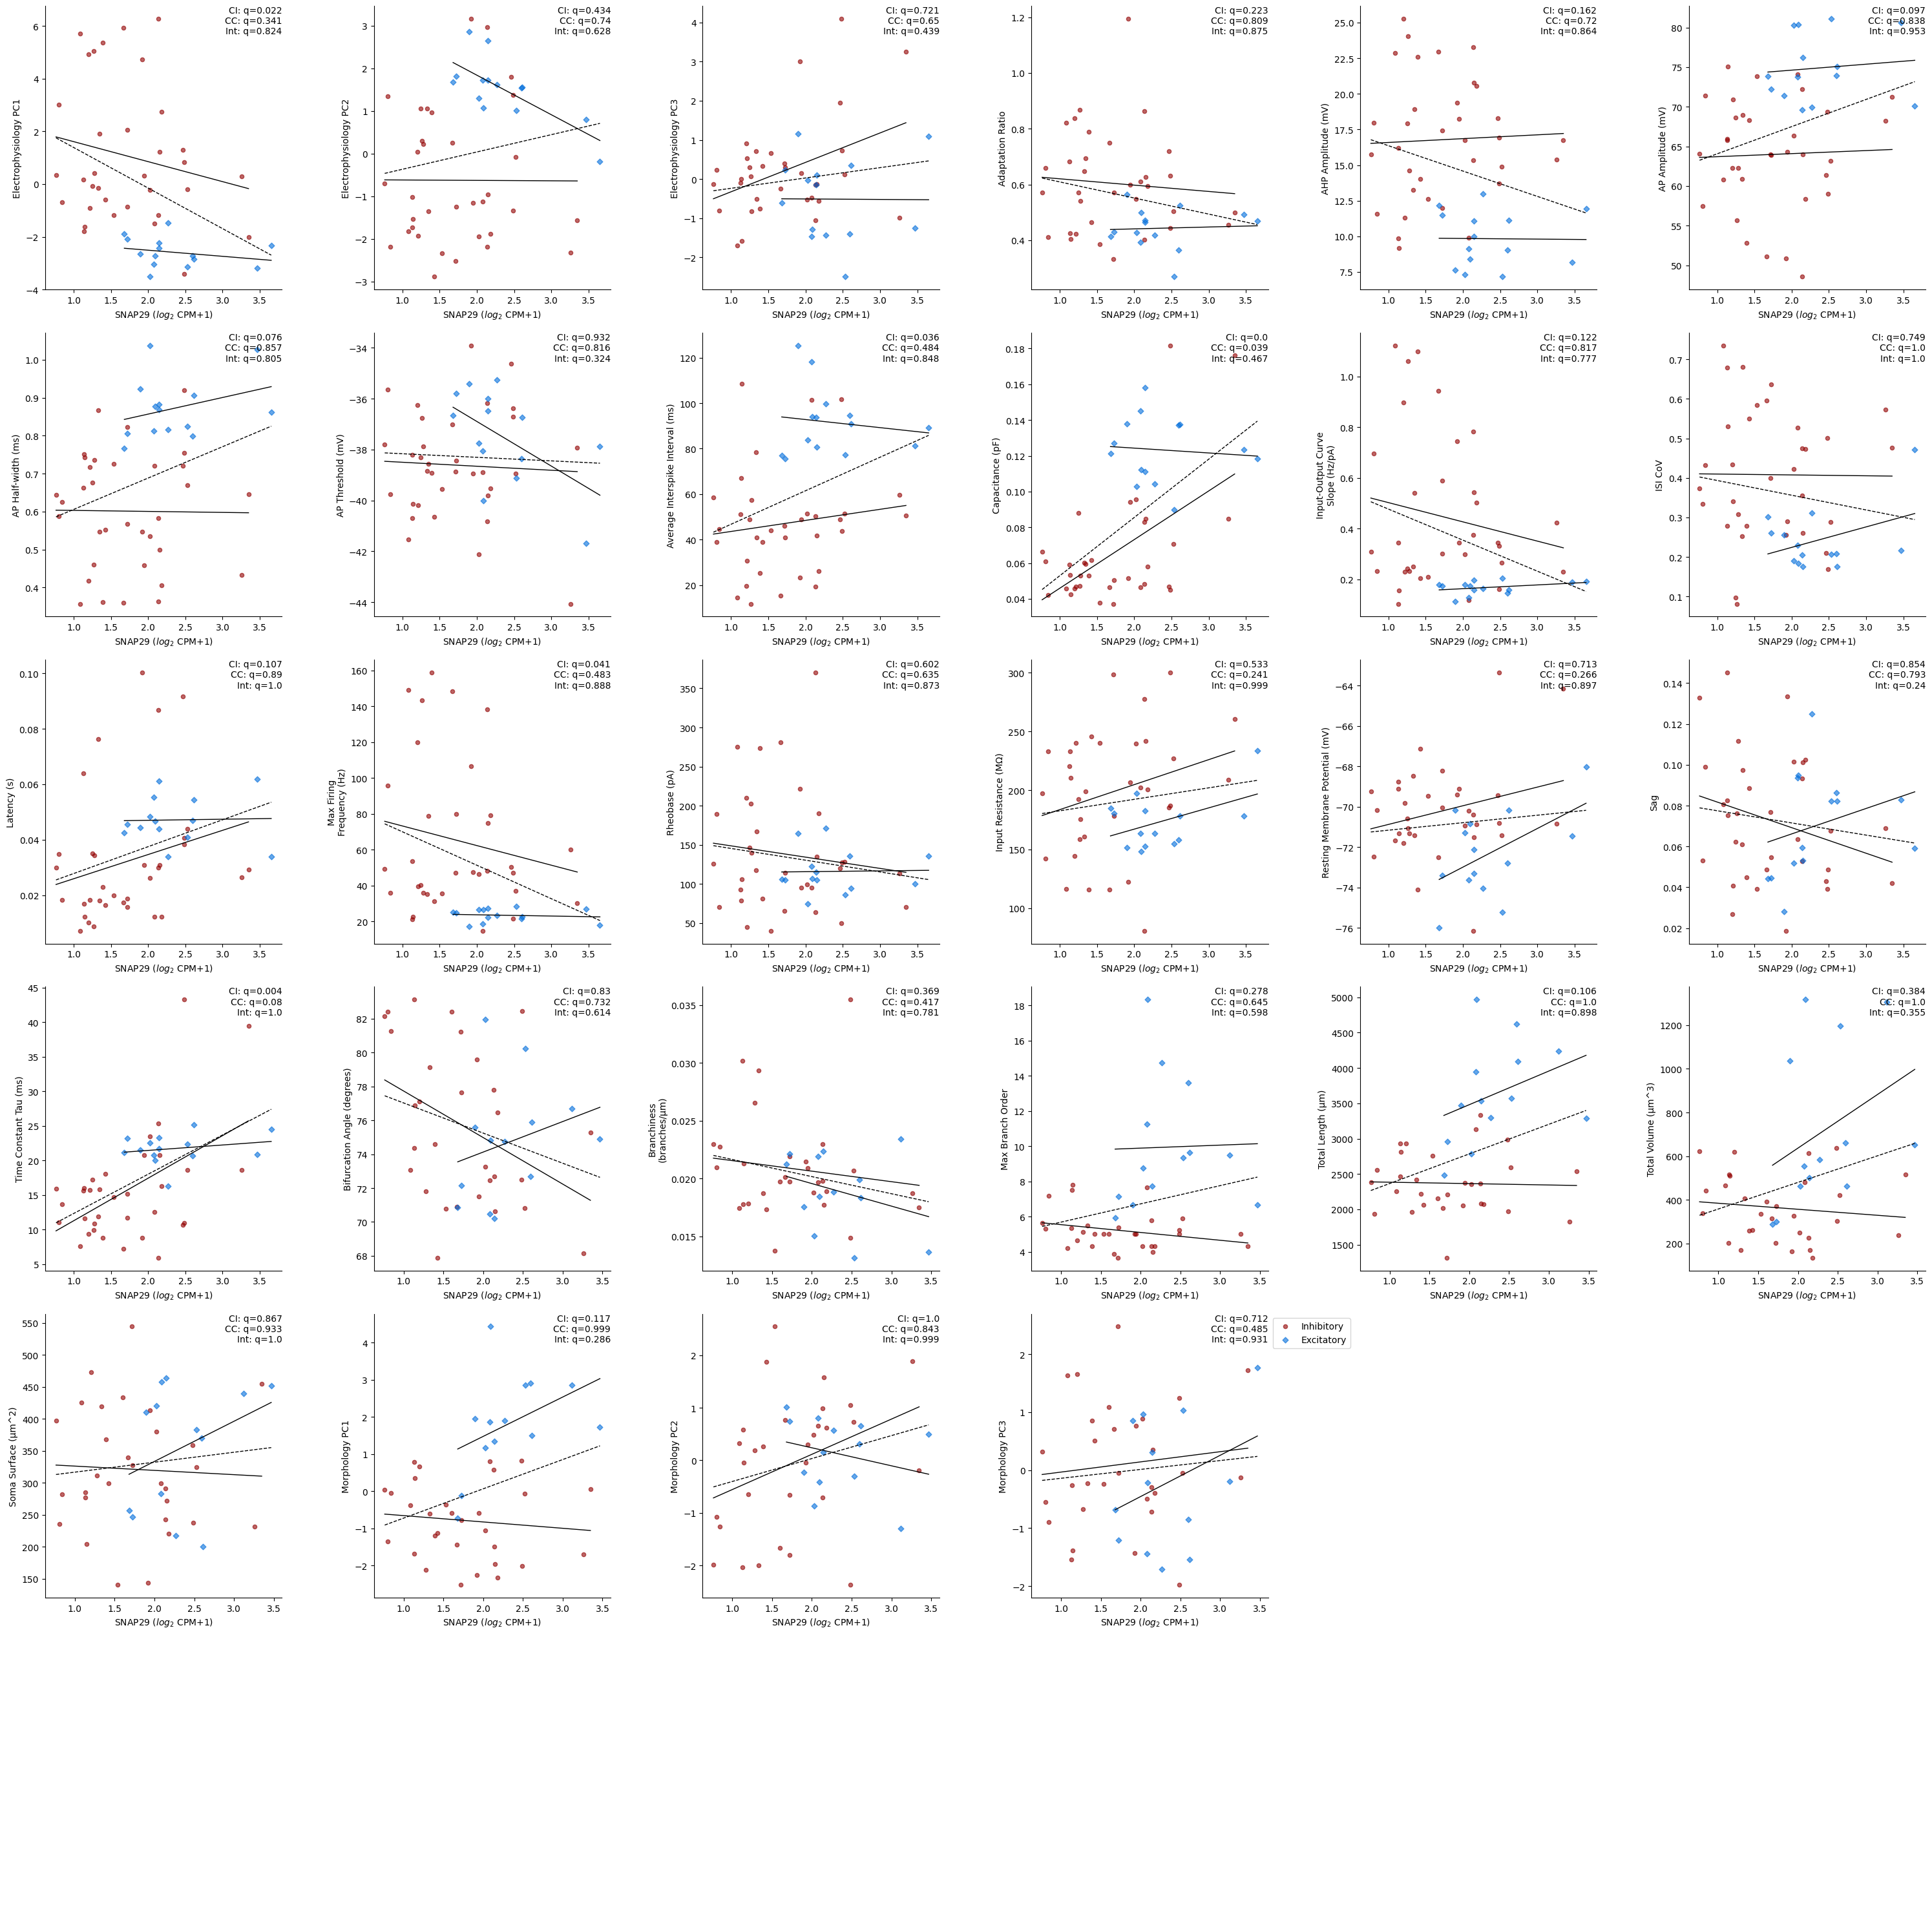

Would you like to see other graphs for another gene of your interest? (Y)es of (N)o: Y
Enter a gene for which you would like to create your graphs: YKT6


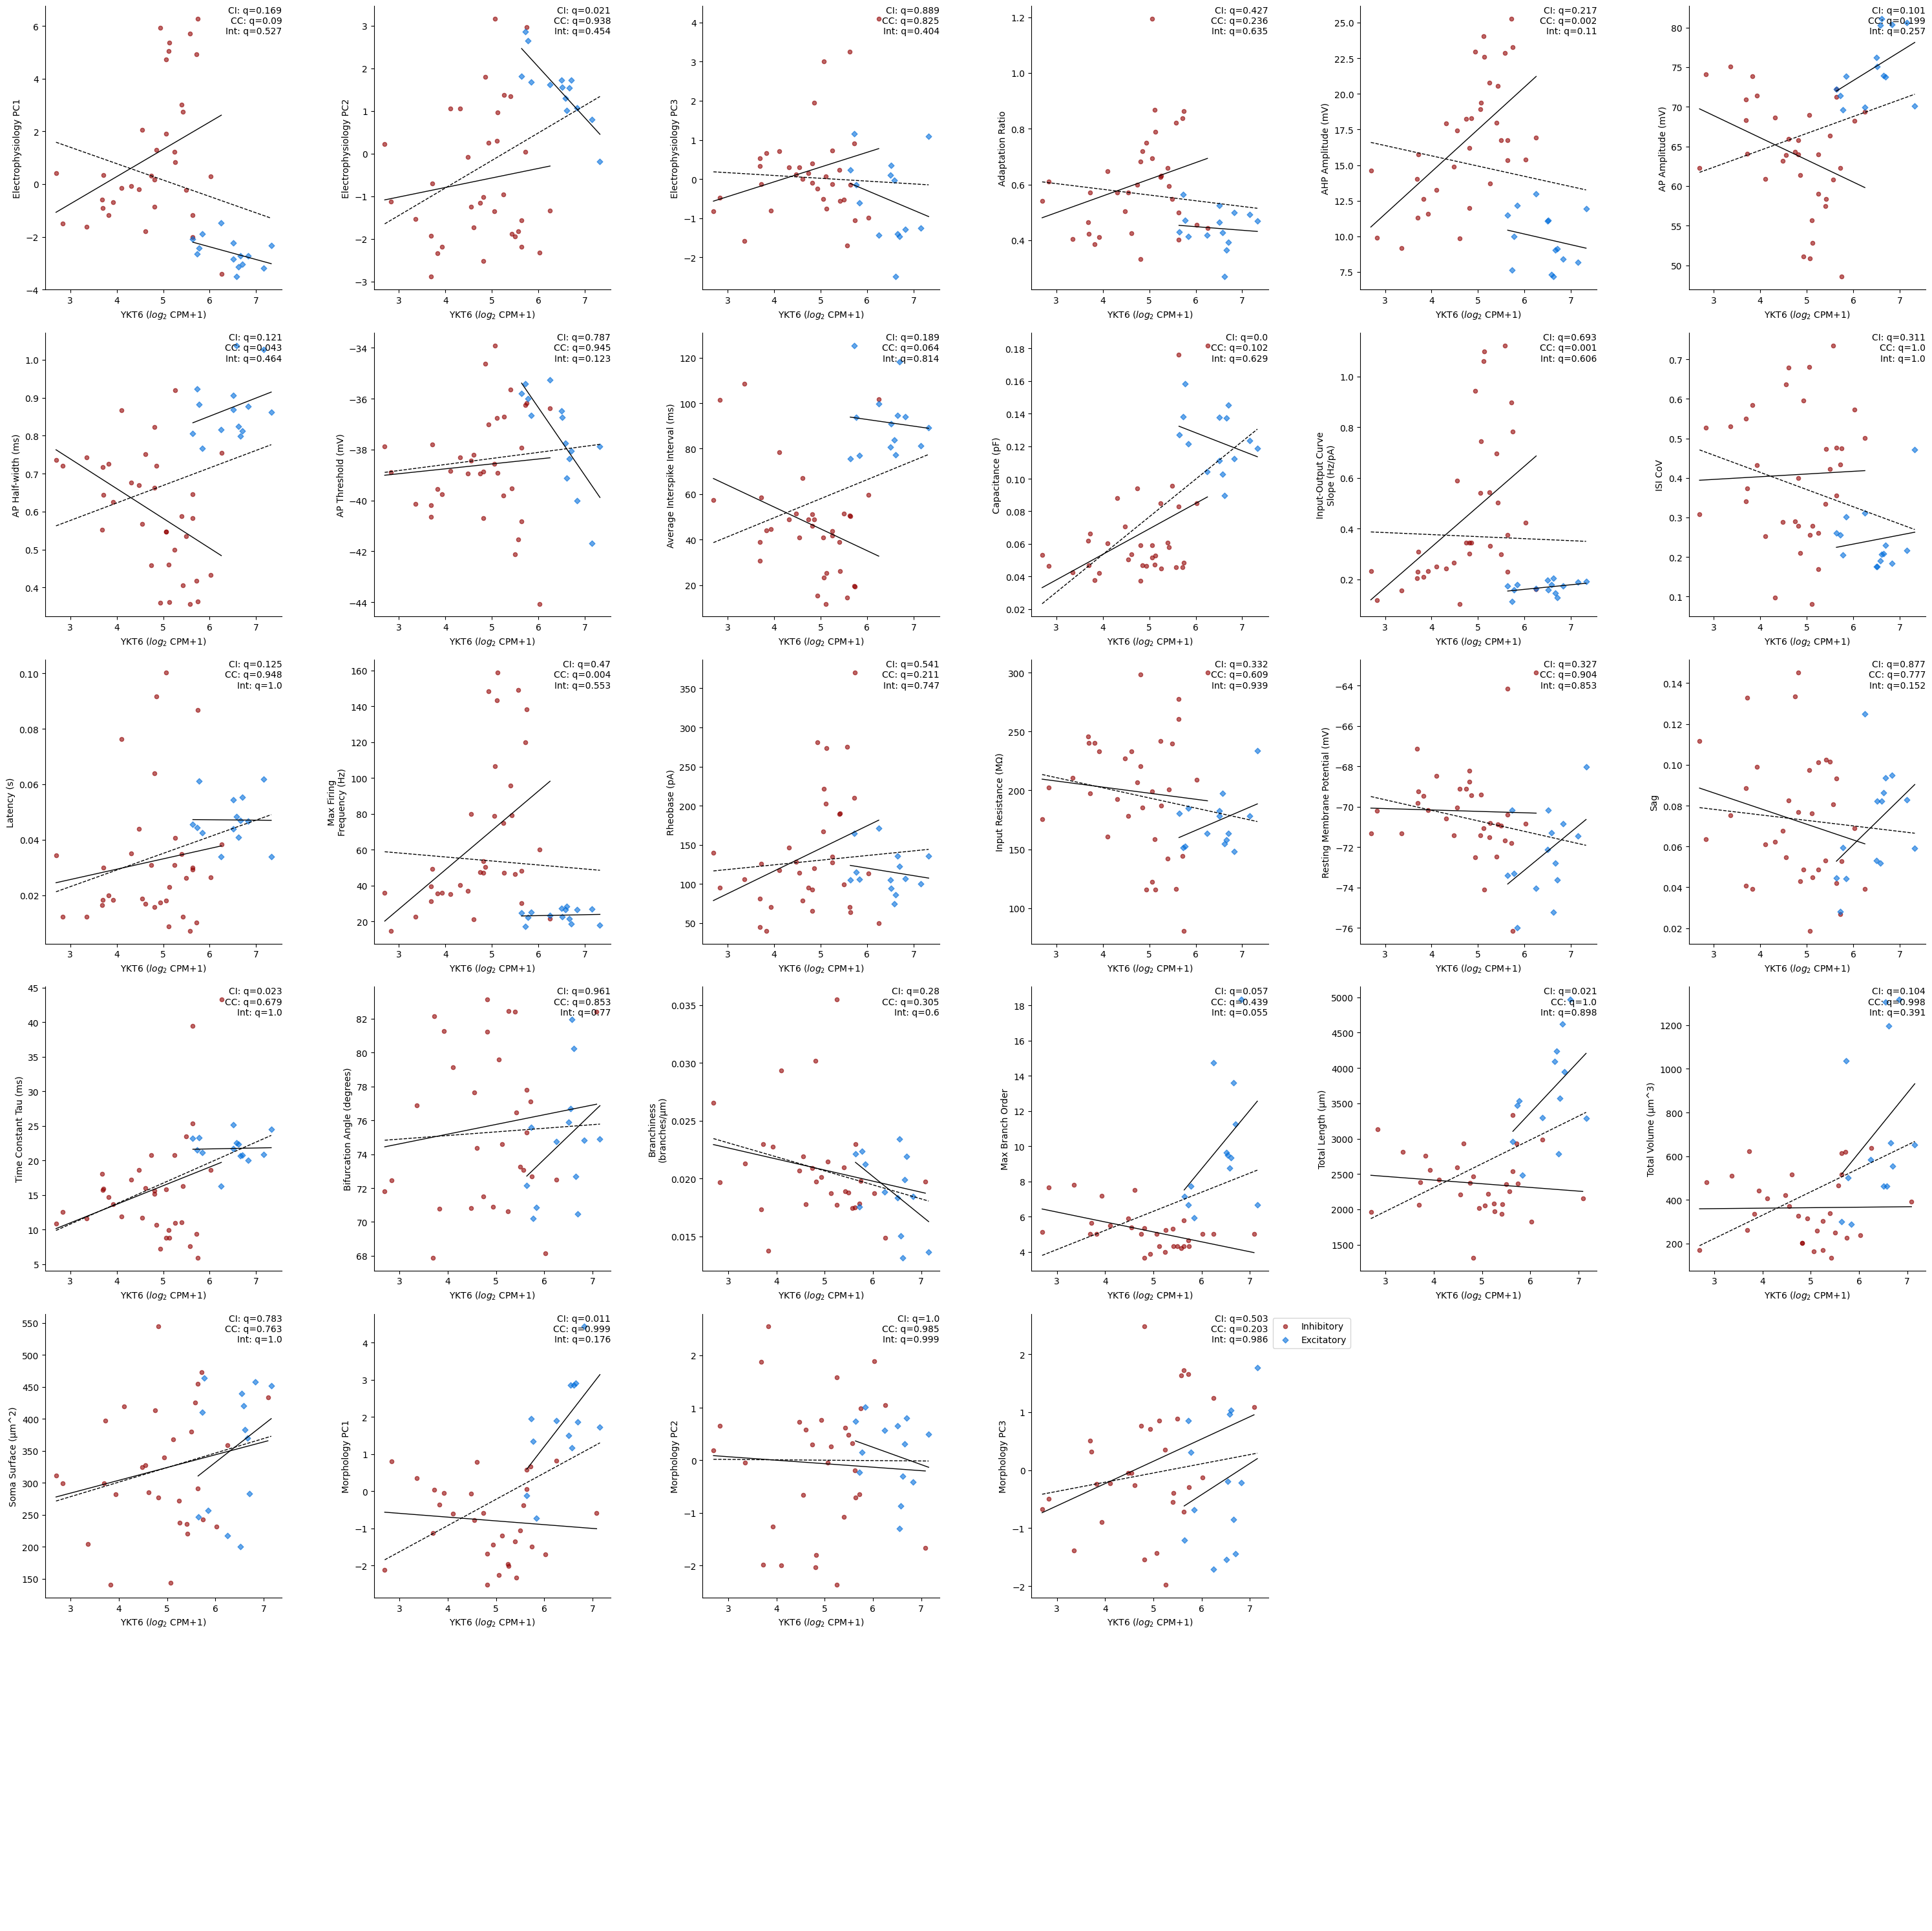

Would you like to see other graphs for another gene of your interest? (Y)es of (N)o: N


In [9]:
#Code for printing scatter plots for one gene's correlations
##Problem: Graph's dimensions kind of weird, will probably have to change them 
def print_graph(x):
    gene = x.upper()
    measures = props_ephys + props_morph
    genes = [gene] * len(measures)
    # Set up axes
    xy = int(math.ceil(np.sqrt(len(genes))))
    fig, axes = plt.subplots(xy, xy, figsize = (xy * 5, xy * 5))

    for graph_gene, measure, ax in zip(genes, measures, axes.flat):
        make_scatter(gene, measure, ax)
    make_legend(ax)
    for ax in axes.flat[len(genes):]:
        ax.axis('off')   
    fig.tight_layout()
    plt.show()

#Loop that keeps asking user if they would like to print graphs for their genes until they say No
ask_for_graph = True
while ask_for_graph == True:
    ask_gene = input("Enter a gene for which you would like to create your graphs: ")
    print_graph(ask_gene)
    again = input("Would you like to see other graphs for another gene of your interest? (Y)es of (N)o: ")
    if again.lower() == "n":
        ask_for_graph = False